### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 11.2 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
import sqlite3
DB_FILE_MLFLOW="lead_scoring_model_experimentation.db"
conn = sqlite3.connect(DB_FILE_MLFLOW)


In [7]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [8]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
TRACKING_URI="http://0.0.0.0:6006"
mlflow.set_tracking_uri(TRACKING_URI)

In [9]:
# setup pycaret 
import pycaret
print(pycaret.__version__)

2.3.8


In [10]:
Baseline_model_experiment01 = setup(data = dataset, target = 'app_complete_flag',
                       session_id = 42,fix_imbalance=False,
                       n_jobs=-1,use_gpu=False,
                       log_experiment=True,experiment_name='Baseline_model_experiment01',
                       log_plots=True, log_data=True,
                       silent=True, verbose=True,
                       log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [11]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
# Create a list of models to exclude
exclude_models = ['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada']
#top_models = compare_models(include = [ 'xgboost'])
# Compare models with exclusion
top_models = compare_models(exclude=exclude_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7388,0.8211,0.8329,0.7027,0.7623,0.4770,0.4856,1.5270
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8292,0.7037,0.7613,0.4766,0.4845,10.4550
rf,Random Forest Classifier,0.7372,0.8188,0.8245,0.7037,0.7593,0.4738,0.4811,3.7470
et,Extra Trees Classifier,0.7367,0.8180,0.8214,0.7043,0.7583,0.4730,0.4798,4.7600
dt,Decision Tree Classifier,0.7364,0.8170,0.8208,0.7041,0.7580,0.4723,0.4791,0.2140
lr,Logistic Regression,0.7099,0.7836,0.8221,0.6733,0.7403,0.4192,0.4299,1.9220
lda,Linear Discriminant Analysis,0.7005,0.7732,0.7962,0.6701,0.7278,0.4003,0.4077,0.6080
ridge,Ridge Classifier,0.7004,0.0000,0.7960,0.6702,0.7277,0.4002,0.4076,0.0630
nb,Naive Bayes,0.6625,0.7334,0.8931,0.6128,0.7268,0.3232,0.3646,0.0650


In [12]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5) 

In [13]:
# create feature importance plot
%matplotlib inline

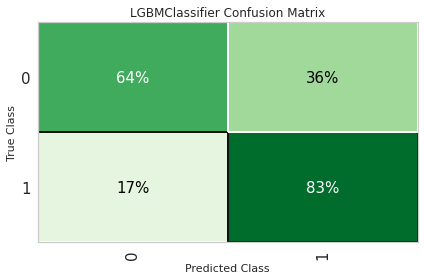

In [14]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

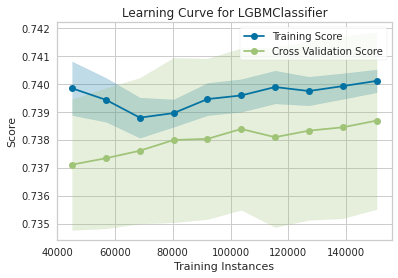

In [15]:
plot_model(lgbm, plot = 'learning')

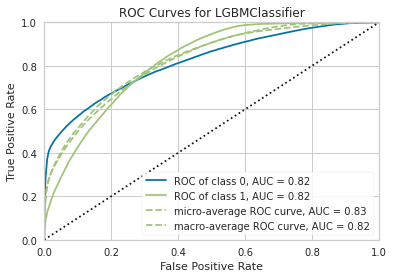

In [16]:
plot_model(lgbm, plot = 'auc')

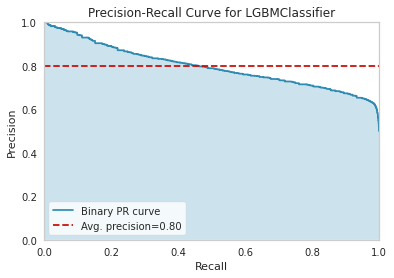

In [17]:
plot_model(lgbm, plot = 'pr')

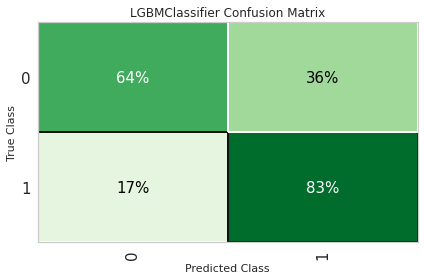

In [18]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

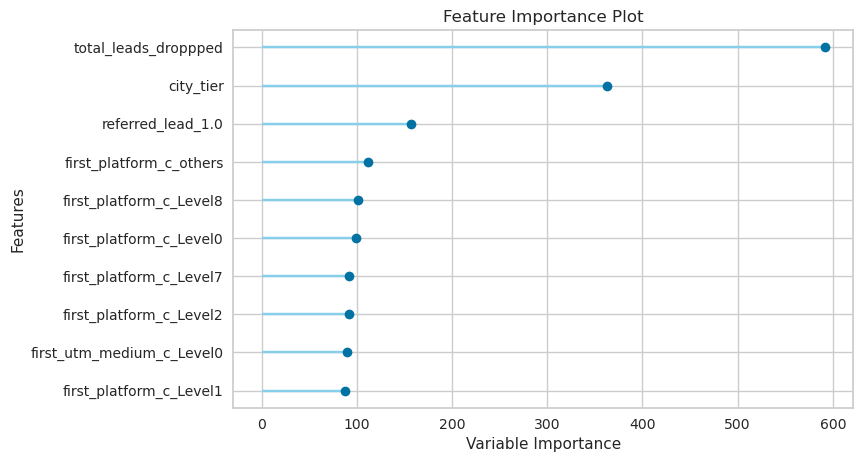

In [19]:
plot_model(lgbm, plot = 'feature')

In [20]:
!pip install shap

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


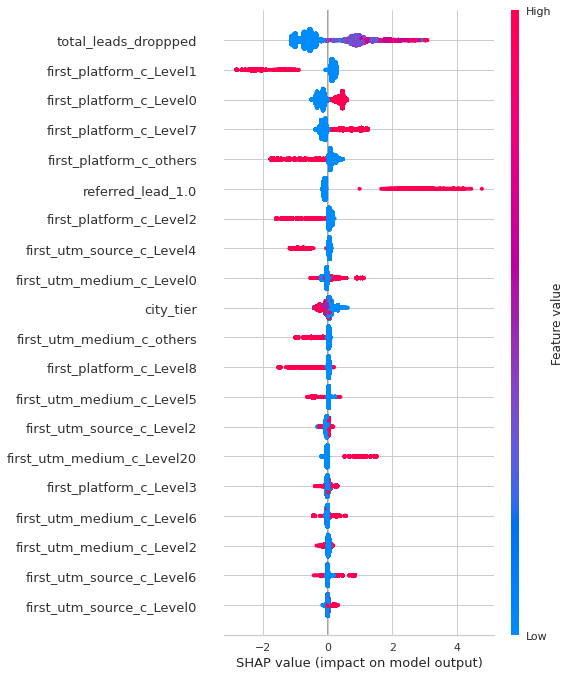

In [21]:
interpret_model(lgbm)

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [22]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
import warnings

# Suppress the warning
warnings.filterwarnings("ignore", category=FutureWarning)
#data_orig = dataset.copy()
print(dataset.columns)
data=dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]
print(data.columns)




Index(['city_tier', 'first_platform_c', 'first_utm_medium_c',
       'first_utm_source_c', 'total_leads_droppped', 'referred_lead',
       'app_complete_flag', 'assistance_interaction', 'career_interaction',
       'payment_interaction', 'social_interaction', 'syllabus_interaction'],
      dtype='object')
Index(['total_leads_droppped', 'city_tier', 'referred_lead',
       'app_complete_flag', 'first_platform_c', 'first_utm_medium_c',
       'first_utm_source_c'],
      dtype='object')


In [23]:
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

Significant_model_experiment01 = setup(data = dataset, target = 'app_complete_flag',
                       session_id = 42,fix_imbalance=False,
                       n_jobs=-1,use_gpu=False,
                       log_experiment=True,experiment_name='Significant_model_experiment01',
                       log_plots=True, log_data=True,
                       silent=True, verbose=True,
                       normalize = False,transformation = False,
                       log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada'].

# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
# Create a list of models to exclude
exclude_models = ['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada']
#top_models = compare_models(include = [ 'xgboost'])
# Compare models with exclusion
top_models = compare_models(exclude=exclude_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7388,0.8211,0.8329,0.7027,0.7623,0.4770,0.4856,1.5480
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8292,0.7037,0.7613,0.4766,0.4845,9.4910
rf,Random Forest Classifier,0.7372,0.8188,0.8245,0.7037,0.7593,0.4738,0.4811,3.7470
et,Extra Trees Classifier,0.7367,0.8180,0.8214,0.7043,0.7583,0.4730,0.4798,4.6810
dt,Decision Tree Classifier,0.7364,0.8170,0.8208,0.7041,0.7580,0.4723,0.4791,0.2160
lr,Logistic Regression,0.7099,0.7836,0.8221,0.6733,0.7403,0.4192,0.4299,1.9510
lda,Linear Discriminant Analysis,0.7005,0.7732,0.7962,0.6701,0.7278,0.4003,0.4077,0.6710
ridge,Ridge Classifier,0.7004,0.0000,0.7960,0.6702,0.7277,0.4002,0.4076,0.1020
nb,Naive Bayes,0.6625,0.7334,0.8931,0.6128,0.7268,0.3232,0.3646,0.0600


In [25]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
significant_lgbm  = create_model('lightgbm', fold = 5) 

In [26]:
!pip install  optuna

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

def objective(trial):
    # Define the hyperparameters to search
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'verbosity': -1,
        'boost_from_average': 'false',
        'num_threads': 4,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
    }

    # Create a list to store AUC scores for each fold
    auc_scores = []

    # Perform k-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create and train a LightGBM model
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC for this fold
        fold_auc = roc_auc_score(y_val_fold, y_pred)
        auc_scores.append(fold_auc)

    # Return the average AUC score over all folds
    return sum(auc_scores) / len(auc_scores)


In [28]:
from sklearn.metrics import roc_auc_score
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other hyperparameters to optimize here
    }
    
    # Create a model with the current hyperparameters
    model = create_model('lightgbm', **params)

    # Evaluate the model using a metric of your choice (e.g., AUC)
    auc = roc_auc_score(get_config('y_test'), predict_model(model)['Score'])
    
    return auc

In [29]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials as needed

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7243,0.7983,0.8962,0.6671,0.7648,0.4484,0.4775


[I 2023-09-15 04:16:59,584] Trial 9 finished with value: 0.40296422692252265 and parameters: {'num_leaves': 13, 'learning_rate': 0.005056031692652955}. Best is trial 1 with value: 0.42295997602752433.


In [30]:
best_params = study.best_params

In [31]:
best_params

{'num_leaves': 67, 'learning_rate': 0.0012523074616187554}

In [32]:
print(study)

In [33]:
FEATURES_TO_ENCODE = [ 'first_platform_c', 'first_utm_medium_c' ,'first_utm_source_c']
print("Before encoding data shape ({}): {}".format(len(data.columns),','.join(data.columns)))
print("Before encoding data shape : {}".format(data.shape))
for f in FEATURES_TO_ENCODE:
    if(f in data.columns):
        encoded = pd.get_dummies(data[f])
        encoded = encoded.add_prefix(f + '_')
        data = pd.concat([data,encoded],axis=1)
    else:
        print("Feature {} not found".format(f))
data.drop(columns=FEATURES_TO_ENCODE,inplace=True)
print("After encoding data shape ({}): {}".format(len(data.columns),','.join(data.columns)))
print("After encoding data shape : {}".format(data.shape))

Before encoding data shape (7): total_leads_droppped,city_tier,referred_lead,app_complete_flag,first_platform_c,first_utm_medium_c,first_utm_source_c
Before encoding data shape : (238964, 7)
After encoding data shape (39): total_leads_droppped,city_tier,referred_lead,app_complete_flag,first_platform_c_Level0,first_platform_c_Level1,first_platform_c_Level2,first_platform_c_Level3,first_platform_c_Level7,first_platform_c_Level8,first_platform_c_others,first_utm_medium_c_Level0,first_utm_medium_c_Level10,first_utm_medium_c_Level11,first_utm_medium_c_Level13,first_utm_medium_c_Level15,first_utm_medium_c_Level16,first_utm_medium_c_Level2,first_utm_medium_c_Level20,first_utm_medium_c_Level26,first_utm_medium_c_Level3,first_utm_medium_c_Level30,first_utm_medium_c_Level33,first_utm_medium_c_Level4,first_utm_medium_c_Level43,first_utm_medium_c_Level5,first_utm_medium_c_Level6,first_utm_medium_c_Level8,first_utm_medium_c_Level9,first_utm_medium_c_others,first_utm_source_c_Level0,first_utm_source

In [34]:
# Print the final models configuration so that we can use it in the model retraining pipeline 

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X = data.drop(columns=['app_complete_flag'])  # Replace 'target_column_name' with your actual target column name
y = data['app_complete_flag']

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
import warnings

# Suppress the warning
warnings.filterwarnings("ignore", category=FutureWarning)
import lightgbm as lgb
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.0012523074616187554,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=67,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [39]:
print(final_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.0012523074616187554,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=67,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
